In [19]:
import sys

sys.path.insert(0, '/home/jianx/search-exposure/')
import torch
from annoy import AnnoyIndex
import forward_ranker.load_data as load_data
import forward_ranker.train as train
from forward_ranker.utils import print_message
from forward_ranker.test import get_ndcg_precision_rr
obj_reader = load_data.obj_reader
obj_writer = load_data.obj_writer
import pickle
import numpy as np
import pandas as pd
import random
import math
import  matplotlib.pyplot as plt

In [20]:
GROUND_TRUTH_PATH = "/datadrive/jianx/data/results/all_search_rankings_100_100_flat.csv"
P_FORWARD = 0.7
P_REVERSE = 0.9

In [21]:
def load_ground_truth(path, p=P_FORWARD):
    all_results = {}
    with open(path, "r") as f:
        for line in f:
            qid = int(line.split(",")[0])
            pid = int(line.split(",")[1])
            rank = int(line.split(",")[2])
            if pid not in all_results.keys():
                all_results[pid] = {}
            all_results[pid][qid] = p ** rank
    return all_results

In [8]:
ratings = load_ground_truth(GROUND_TRUTH_PATH, P_FORWARD)

In [4]:
# Full
baseline_full = obj_reader("/datadrive/ruohan/reverse_ranker/residual/loss15_layer3/forward_baseline_rank_test.pickle")
append_full = obj_reader("/datadrive/ruohan/reverse_ranker/append/layer3_no_split/pred_rank_test.pickle")
residual_full = obj_reader("/datadrive/ruohan/reverse_ranker/residual/loss15_layer3/pred_rank_test.pickle")

In [5]:
# Half
baseline_half = obj_reader("/datadrive/ruohan/reverse_ranker/residual/train_query_250000/forward_baseline_rank_test.pickle")
append_half = obj_reader("/datadrive/ruohan/reverse_ranker/append/train_query_250000/pred_rank_test.pickle")
residual_half = obj_reader("/datadrive/ruohan/reverse_ranker/residual/train_query_250000/pred_rank_test.pickle")

# 1/10
baseline_110 = obj_reader("/datadrive/ruohan/reverse_ranker/residual/train_query_50000/forward_baseline_rank_test.pickle")
append_110 = obj_reader("/datadrive/ruohan/reverse_ranker/append/train_query_50000/pred_rank_test.pickle")
residual_110 = obj_reader("/datadrive/ruohan/reverse_ranker/residual/train_query_50000/pred_rank_test.pickle")

# 1/10 sample from query
baseline_q = obj_reader("/datadrive/ruohan/reverse_ranker/residual/train_query_50000_morepos/forward_baseline_rank_test.pickle")
append_q = obj_reader("/datadrive/ruohan/reverse_ranker/append/train_query_50000_morepos/pred_rank_test.pickle")
residual_q = obj_reader("/datadrive/ruohan/reverse_ranker/residual/train_query_50000_morepos/pred_rank_test.pickle")

In [22]:
def get_reverse_nrbp_rr(true_dict, test_dict, rank, p):
    sorted_result = list(test_dict.items())
    rank = min(rank, len(sorted_result))
    cumulative_gain = 0
    rr = float("NaN")
    for i in range(len(sorted_result)):
        pid = sorted_result[i][0]
        if pid in true_dict:
            rr = 1 / (i + 1)
            break
    for i in range(rank):
        pid = sorted_result[i][0]
        relevance = 0
        if pid in true_dict:
            relevance = true_dict[pid]
        discounted_gain = relevance * (p ** i)
        cumulative_gain += discounted_gain
    sorted_ideal = sorted(true_dict.items(), key=lambda x: x[1], reverse=True)
    ideal_gain = 0
    for i in range(rank):
        relevance = 0
        if i < len(sorted_ideal):
            relevance = sorted_ideal[i][1]
        discounted_gain = relevance * (p ** i)
        ideal_gain += discounted_gain
    nrbp = 0
    if ideal_gain != 0:
         nrbp = cumulative_gain / ideal_gain
    return nrbp, rr

def calculate_metrics(rating_dict, result_dict, rank=10, p=P_REVERSE):
    pids = list(result_dict.keys())
    result_nrbp = []
    result_rr = []
    for pid in pids:
        if pid in rating_dict:
            nrbp, rr = get_reverse_nrbp_rr(rating_dict[pid], result_dict[pid], rank, p)
            result_nrbp.append(nrbp)
            result_rr.append(rr)
    avg_nrbp = np.nanmean(result_nrbp)
    avg_rr = np.nanmean(result_rr)
    print("NRBP@{}: {:.4f}".format(rank,avg_nrbp), "RR: {:.4f}".format(avg_rr))
    return avg_nrbp

In [60]:
def grid_nrbp(p_forwards, p_reverses, baseline_dict, result_dict):
    x = []
    y = []
    data = []
    for p_forward in p_forwards:
        rating_dict = load_ground_truth(GROUND_TRUTH_PATH, p_forward)
        for p_reverse in p_reverses:
            x.append(p_forward)
            y.append(p_reverse)
            baseline_nrbp = calculate_metrics(rating_dict, baseline_dict, 10, p_reverse)
            model_nrbp = calculate_metrics(rating_dict, result_dict, 10, p_reverse)
            data.append((model_nrbp-baseline_nrbp)/baseline_nrbp)
            print_message("Processed p_forward={}, p_reverse={}".format(p_forward, p_reverse))
    return x, y, data

In [33]:
x, y, data = grid_nrbp(np.arange(0.1, 1, 0.2), np.arange(0.1, 1, 0.2), baseline_half, append_half)

NRBP@10: 0.4219 RR: 0.7910
NRBP@10: 0.5647 RR: 0.9015
[Sep 18, 01:33:27] Processed p_forward=0.1, p_reverse=0.1
NRBP@10: 0.4521 RR: 0.7910
NRBP@10: 0.6016 RR: 0.9015
[Sep 18, 01:33:28] Processed p_forward=0.1, p_reverse=0.30000000000000004
NRBP@10: 0.4940 RR: 0.7910
NRBP@10: 0.6512 RR: 0.9015
[Sep 18, 01:33:29] Processed p_forward=0.1, p_reverse=0.5000000000000001
NRBP@10: 0.5579 RR: 0.7910
NRBP@10: 0.7227 RR: 0.9015
[Sep 18, 01:33:30] Processed p_forward=0.1, p_reverse=0.7000000000000001
NRBP@10: 0.6711 RR: 0.7910
NRBP@10: 0.8382 RR: 0.9015
[Sep 18, 01:33:31] Processed p_forward=0.1, p_reverse=0.9000000000000001
NRBP@10: 0.4275 RR: 0.7910
NRBP@10: 0.5708 RR: 0.9015
[Sep 18, 01:36:15] Processed p_forward=0.30000000000000004, p_reverse=0.1
NRBP@10: 0.4570 RR: 0.7910
NRBP@10: 0.6069 RR: 0.9015
[Sep 18, 01:36:16] Processed p_forward=0.30000000000000004, p_reverse=0.30000000000000004
NRBP@10: 0.4980 RR: 0.7910
NRBP@10: 0.6554 RR: 0.9015
[Sep 18, 01:36:17] Processed p_forward=0.300000000000

0.02837571628389748
[0.338453945914586, 0.3306796470787471, 0.31823767231945066, 0.2955355017865219, 0.24887508236774944, 0.33494187187749946, 0.32790747809139814, 0.31623797697655515, 0.2943343796507509, 0.2484778139261612, 0.3300518320010972, 0.32428268196947563, 0.31385097870521067, 0.29316001001395275, 0.24847894088387099, 0.3226089270410243, 0.31909954399447404, 0.3108698441376954, 0.29230026580476054, 0.24965618432840306, 0.3033727743190981, 0.3056477463446459, 0.3038798774813953, 0.2926088899136816, 0.25845581675909496]


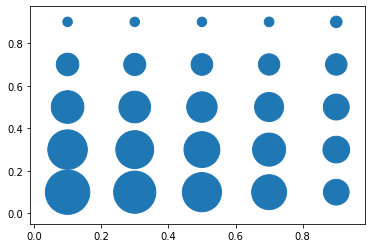

In [59]:
print(np.std(data))
print(data)
plt.scatter(x, y, s=[i ** 10 * 100000000 for i in data])

In [61]:
x_rc, y_rc, data_rc = grid_nrbp(np.arange(0.1, 1.1, 0.1), np.arange(0.1, 1.1, 0.1), baseline_q, append_q)

NRBP@10: 0.4213 RR: 0.7903
NRBP@10: 0.5254 RR: 0.8743
[Sep 18, 02:02:57] Processed p_forward=0.1, p_reverse=0.1
NRBP@10: 0.4350 RR: 0.7903
NRBP@10: 0.5428 RR: 0.8743
[Sep 18, 02:02:57] Processed p_forward=0.1, p_reverse=0.2
NRBP@10: 0.4509 RR: 0.7903
NRBP@10: 0.5628 RR: 0.8743
[Sep 18, 02:02:58] Processed p_forward=0.1, p_reverse=0.30000000000000004
NRBP@10: 0.4697 RR: 0.7903
NRBP@10: 0.5860 RR: 0.8743
[Sep 18, 02:02:59] Processed p_forward=0.1, p_reverse=0.4
NRBP@10: 0.4925 RR: 0.7903
NRBP@10: 0.6133 RR: 0.8743
[Sep 18, 02:03:00] Processed p_forward=0.1, p_reverse=0.5
NRBP@10: 0.5207 RR: 0.7903
NRBP@10: 0.6462 RR: 0.8743
[Sep 18, 02:03:01] Processed p_forward=0.1, p_reverse=0.6
NRBP@10: 0.5567 RR: 0.7903
NRBP@10: 0.6870 RR: 0.8743
[Sep 18, 02:03:02] Processed p_forward=0.1, p_reverse=0.7000000000000001
NRBP@10: 0.6047 RR: 0.7903
NRBP@10: 0.7393 RR: 0.8743
[Sep 18, 02:03:02] Processed p_forward=0.1, p_reverse=0.8
NRBP@10: 0.6710 RR: 0.7903
NRBP@10: 0.8089 RR: 0.8743
[Sep 18, 02:03:03] 

0.021326571452860214
[0.2469200848053003, 0.2479275548830771, 0.2482014076691523, 0.24746245342398993, 0.24529962090292812, 0.24109443137019068, 0.23393456427636036, 0.22256744452311197, 0.20550179638198654, 0.18139712890697404, 0.24612120728902948, 0.24723747967754317, 0.24761828381502912, 0.2469834438357826, 0.24492166605907503, 0.24081440993676642, 0.23374856164017516, 0.22246849759093784, 0.20547539179925778, 0.18141444723534697, 0.2451380353549277, 0.2463930342912528, 0.24691008684941343, 0.2464081873519308, 0.2444756305403829, 0.24049322437551396, 0.23354590589066254, 0.22237297694911815, 0.2054648546059335, 0.18144812987148792, 0.243925406061776, 0.2453574741066424, 0.2460485715795871, 0.24571733035587442, 0.24395167286008446, 0.24013123355005503, 0.23333757789159904, 0.2223020800157149, 0.2054996538196157, 0.18153182136841334, 0.24241643865719759, 0.2440747137255872, 0.24498886255532606, 0.24487792841545453, 0.2433297933502273, 0.2397226338353859, 0.23313332813221102, 0.2222824

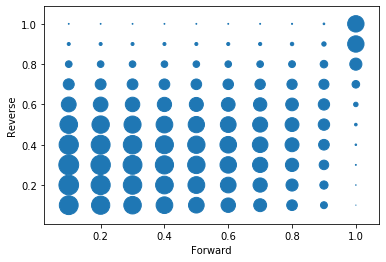

In [78]:
print(np.std(data_rc))
print(data_rc)
plt.xlabel("Forward")
plt.ylabel("Reverse")
plt.scatter(x_rc, y_rc, s=[i ** 20 * 500000000000000 for i in data_rc])

,P_forward,P_reverse,NRBP
0,0.1,0.1,0.246920
1,0.1,0.2,0.247928
2,0.1,0.3,0.248201
3,0.1,0.4,0.247462
4,0.1,0.5,0.245300
...,...,...,...
95,1.0,0.6,0.213782
96,1.0,0.7,0.225522
97,1.0,0.8,0.236285
98,1.0,0.9,0.243469


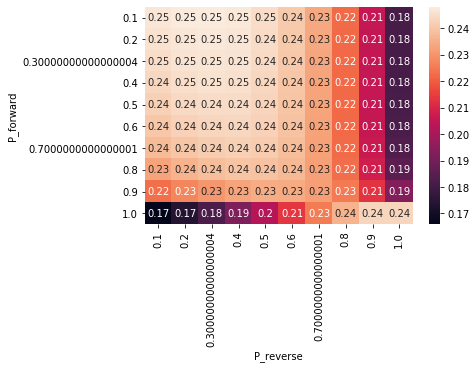

In [100]:
import seaborn as sns
nrbps = pd.DataFrame(data=np.array([x_rc,y_rc,data_rc]).T,columns=["P_forward","P_reverse","NRBP"])
display(nrbps)
nrbps = nrbps.pivot("P_forward","P_reverse","NRBP")
ax = sns.heatmap(nrbps, annot=True)

In [23]:
def grid_nrbp_absolute(p_forwards, p_reverses, result_dict):
    x = []
    y = []
    data = []
    for p_forward in p_forwards:
        rating_dict = load_ground_truth(GROUND_TRUTH_PATH, p_forward)
        for p_reverse in p_reverses:
            x.append(p_forward)
            y.append(p_reverse)
            model_nrbp = calculate_metrics(rating_dict, result_dict, 10, p_reverse)
            data.append(model_nrbp)
    return x, y, data

In [24]:
x_rc, y_rc, data_rc = grid_nrbp_absolute(np.arange(0.1, 1.1, 0.1), np.arange(0.1, 1.1, 0.1), append_q)

NRBP@10: 0.5254 RR: 0.8743
NRBP@10: 0.5428 RR: 0.8743
NRBP@10: 0.5628 RR: 0.8743
NRBP@10: 0.5860 RR: 0.8743
NRBP@10: 0.6133 RR: 0.8743
NRBP@10: 0.6462 RR: 0.8743
NRBP@10: 0.6870 RR: 0.8743
NRBP@10: 0.7393 RR: 0.8743
NRBP@10: 0.8089 RR: 0.8743
NRBP@10: 0.9050 RR: 0.8743
NRBP@10: 0.5280 RR: 0.8743
NRBP@10: 0.5453 RR: 0.8743
NRBP@10: 0.5651 RR: 0.8743
NRBP@10: 0.5880 RR: 0.8743
NRBP@10: 0.6151 RR: 0.8743
NRBP@10: 0.6478 RR: 0.8743
NRBP@10: 0.6883 RR: 0.8743
NRBP@10: 0.7403 RR: 0.8743
NRBP@10: 0.8094 RR: 0.8743
NRBP@10: 0.9049 RR: 0.8743
NRBP@10: 0.5311 RR: 0.8743
NRBP@10: 0.5482 RR: 0.8743
NRBP@10: 0.5678 RR: 0.8743
NRBP@10: 0.5905 RR: 0.8743
NRBP@10: 0.6173 RR: 0.8743
NRBP@10: 0.6496 RR: 0.8743
NRBP@10: 0.6898 RR: 0.8743
NRBP@10: 0.7413 RR: 0.8743
NRBP@10: 0.8100 RR: 0.8743
NRBP@10: 0.9047 RR: 0.8743
NRBP@10: 0.5351 RR: 0.8743
NRBP@10: 0.5519 RR: 0.8743
NRBP@10: 0.5711 RR: 0.8743
NRBP@10: 0.5935 RR: 0.8743
NRBP@10: 0.6199 RR: 0.8743
NRBP@10: 0.6519 RR: 0.8743
NRBP@10: 0.6916 RR: 0.8743
N

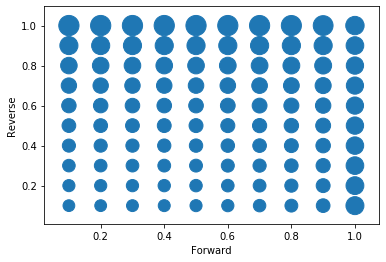

In [26]:
plt.xlabel("Forward")
plt.ylabel("Reverse")
plt.scatter(x_rc, y_rc, s=[i ** 2 * 500 for i in data_rc])

In [17]:
x_rc, y_rc, data_rc = grid_nrbp_absolute(np.arange(0.1, 1.1, 0.1), np.arange(0.1, 1.1, 0.1), baseline_q)

NRBP@10: 0.2948 RR: 0.7903
NRBP@10: 0.3042 RR: 0.7903
NRBP@10: 0.3154 RR: 0.7903
NRBP@10: 0.3290 RR: 0.7903
NRBP@10: 0.3458 RR: 0.7903
NRBP@10: 0.3674 RR: 0.7903
NRBP@10: 0.3959 RR: 0.7903
NRBP@10: 0.4344 RR: 0.7903
NRBP@10: 0.4877 RR: 0.7903
NRBP@10: 0.5623 RR: 0.7903
NRBP@10: 0.2948 RR: 0.7903
NRBP@10: 0.3042 RR: 0.7903
NRBP@10: 0.3154 RR: 0.7903
NRBP@10: 0.3290 RR: 0.7903
NRBP@10: 0.3458 RR: 0.7903
NRBP@10: 0.3674 RR: 0.7903
NRBP@10: 0.3959 RR: 0.7903
NRBP@10: 0.4344 RR: 0.7903
NRBP@10: 0.4877 RR: 0.7903
NRBP@10: 0.5623 RR: 0.7903
NRBP@10: 0.2948 RR: 0.7903
NRBP@10: 0.3042 RR: 0.7903
NRBP@10: 0.3154 RR: 0.7903
NRBP@10: 0.3290 RR: 0.7903
NRBP@10: 0.3458 RR: 0.7903
NRBP@10: 0.3674 RR: 0.7903
NRBP@10: 0.3959 RR: 0.7903
NRBP@10: 0.4344 RR: 0.7903
NRBP@10: 0.4877 RR: 0.7903
NRBP@10: 0.5623 RR: 0.7903
NRBP@10: 0.2948 RR: 0.7903
NRBP@10: 0.3042 RR: 0.7903
NRBP@10: 0.3154 RR: 0.7903
NRBP@10: 0.3290 RR: 0.7903
NRBP@10: 0.3458 RR: 0.7903
NRBP@10: 0.3674 RR: 0.7903
NRBP@10: 0.3959 RR: 0.7903
N

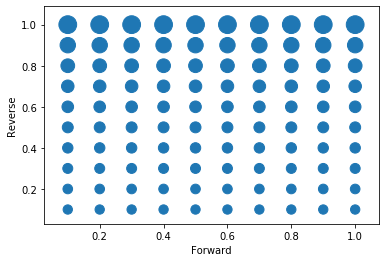

In [18]:
plt.xlabel("Forward")
plt.ylabel("Reverse")
plt.scatter(x_rc, y_rc, s=[i ** 2 * 1000 for i in data_rc])

In [12]:
print("With full query log")
print("Baseline forward embedding model")
calculate_metrics(ratings, baseline_full)
calculate_metrics(ratings, baseline_full, 100)
print("Append embedding model")
calculate_metrics(ratings, append_full)
calculate_metrics(ratings, append_full, 100)
print("Residual embedding model")
calculate_metrics(ratings, residual_full)
calculate_metrics(ratings, residual_full, 100)

With full query log
Baseline forward embedding model
NRBP@10: 0.6702 RR: 0.7892
NRBP@100: 0.6927 RR: 0.7892
Append embedding model
NRBP@10: 0.8474 RR: 0.9073
NRBP@100: 0.8598 RR: 0.9073
Residual embedding model
NRBP@10: 0.8624 RR: 0.9096
NRBP@100: 0.8731 RR: 0.9096


In [13]:
print("With half query log")
print("Baseline forward embedding model")
calculate_metrics(ratings, baseline_half)
calculate_metrics(ratings, baseline_half, 100)
print("Append embedding model")
calculate_metrics(ratings, append_half)
calculate_metrics(ratings, append_half, 100)
print("Residual embedding model")
calculate_metrics(ratings, residual_half)
calculate_metrics(ratings, residual_half, 100)

With half query log
Baseline forward embedding model
NRBP@10: 0.6735 RR: 0.7910
NRBP@100: 0.6968 RR: 0.7910
Append embedding model
NRBP@10: 0.8416 RR: 0.9015
NRBP@100: 0.8547 RR: 0.9015
Residual embedding model
NRBP@10: 0.8222 RR: 0.8780
NRBP@100: 0.8368 RR: 0.8780


In [14]:
print("With 1/10 query log")
print("Baseline forward embedding model")
calculate_metrics(ratings, baseline_110)
calculate_metrics(ratings, baseline_110, 100)
print("Append embedding model")
calculate_metrics(ratings, append_110)
calculate_metrics(ratings, append_110, 100)
print("Residual embedding model")
calculate_metrics(ratings, residual_110)
calculate_metrics(ratings, residual_110, 100)

With 1/10 query log
Baseline forward embedding model
NRBP@10: 0.6666 RR: 0.7913
NRBP@100: 0.6899 RR: 0.7913
Append embedding model
NRBP@10: 0.7541 RR: 0.8201
NRBP@100: 0.7739 RR: 0.8201
Residual embedding model
NRBP@10: 0.7419 RR: 0.8293
NRBP@100: 0.7640 RR: 0.8293


In [15]:
print("Sample from query results")
print("Baseline forward embedding model")
calculate_metrics(ratings, baseline_q)
calculate_metrics(ratings, baseline_q, 100)
print("Append embedding model")
calculate_metrics(ratings, append_q)
calculate_metrics(ratings, append_q, 100)
print("Residual embedding model")
calculate_metrics(ratings, residual_q)
calculate_metrics(ratings, residual_q, 100)

Sample from query results
Baseline forward embedding model
NRBP@10: 0.6736 RR: 0.7903
NRBP@100: 0.6961 RR: 0.7903
Append embedding model
NRBP@10: 0.8127 RR: 0.8743
NRBP@100: 0.8285 RR: 0.8743
Residual embedding model
NRBP@10: 0.7774 RR: 0.8471
NRBP@100: 0.7959 RR: 0.8471
